In [114]:
import os
import itertools
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches

from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.io.matlab import loadmat
from sklearn import manifold, datasets

import rescal
from almc.bayesian_rescal import BayesianRescal, PFBayesianCompRescal


%matplotlib inline

In [19]:
color = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(color)):    
    r, g, b = color[i]    
    color[i] = (r / 255., g / 255., b / 255.)

In [69]:
dataset = 'umls'

if dataset=='umls':
    mat = loadmat('../data/%s/uml.mat' % (dataset))
    T = np.array(mat['Rs'], np.float32)
    cnames = [name[0][0] for name in mat['names']]
    gnames = [name[0] for name in mat['gnames'][0]]
    uniq_gnames = list(np.unique(gnames))
elif dataset=='nation':
    mat = loadmat('../data/%s/dnations.mat' % (dataset))
    T = np.array(mat['R'], np.float32)
    cnames = [i[0] for i in mat['countrynames'][0]]

T = np.swapaxes(T, 1, 2)
T = np.swapaxes(T, 0, 1)  # [relation, entity, entity]
T[np.isnan(T)] = 0

models = ['rescal', 'brescal', 'bcomp_mul', 'bcomp_add', 'logit']
models = ['rescal', 'brescal', 'bcomp_mul']
# models = ['bcomp_mul']

n_dim = 10
n_particle = 1
var_x = 0.1
var_e = 1.
var_r = 1.
var_comp = 1.
n_test = 10
n_iter = 1
max_iter = 0

p=0.30

n_relation, n_entity, _ = T.shape

## Training models & save

In [65]:
rnd = np.random.RandomState(seed=45342412)
np.random.seed(0)

total = n_relation * n_entity * n_entity
indexes = [(k, i, j) for k, i, j in itertools.product(range(n_relation), range(n_entity), range(n_entity))]
rnd.shuffle(indexes)

train = np.zeros_like(T)
for (k, i, j) in indexes[:int(p * len(indexes))]:
    train[k, i, j] = 1

print('Train Sum', np.sum(T[train == 1]), np.sum(train))
for model in models:
    # destination folder where model and log files are saved
    dest = '../result_visualisation/%s/' % (dataset)
    if model == 'bcomp_add' or model == 'bcomp_mul':
        output_file = os.path.join(dest, '%s_%.2f_%d_%.2f_%.2f_training_error.pkl' % (
        model, p, n_dim, var_x, var_comp))
    else:
        output_file = os.path.join(dest, '%s_%.2f_%d_training_error.pkl' % (model, p, n_dim))

    if not os.path.exists(dest):
        os.makedirs(dest, exist_ok=True)

    if model == 'rescal':
        X = list()
        for k in range(n_relation):
            X.append(csr_matrix(train[k]))

        E, R, f, itr, exectimes = rescal.rescal_als(X, n_dim)
        pickle.dump(E, open(output_file, 'wb'))

    elif model == 'brescal':
        model = BayesianRescal(n_dim, var_e=var_e, var_x=var_x, var_r=var_r)
        model.fit(train, max_iter=100)

        Es = np.zeros([n_iter, n_entity, n_dim])
        for nt in range(n_iter):
            model._gibbs(train, max_iter=10)
            Es[nt] = model.E
        pickle.dump(Es, open(output_file, 'wb'))
            
    elif model == 'bcomp_mul':
        _model = PFBayesianCompRescal(n_dim, compositionality='multiplicative', var_x=var_x,
                                      var_comp=var_comp,
                                      n_particles=n_particle, compute_score=False)
        Es = np.zeros([n_iter, n_entity, n_dim])        
        _model.fit(T, train, 0)
        Es[0] = _model.E[0]
        pickle.dump(Es, open(output_file, 'wb'))            


2016-05-17 17:08:04 INFO:almc.bayesian_rescal.seq_bcomp_rescal:Original size: 6752
INFO:almc.bayesian_rescal.seq_bcomp_rescal:Original size: 6752
2016-05-17 17:08:04 INFO:almc.bayesian_rescal.seq_bcomp_rescal:Expanded size 565470
INFO:almc.bayesian_rescal.seq_bcomp_rescal:Expanded size 565470
2016-05-17 17:08:04 INFO:almc.bayesian_rescal.seq_bcomp_rescal:Original shape: (49, 135, 135)
INFO:almc.bayesian_rescal.seq_bcomp_rescal:Original shape: (49, 135, 135)
2016-05-17 17:08:04 INFO:almc.bayesian_rescal.seq_bcomp_rescal:Expanded shape: (2450, 135, 135)
INFO:almc.bayesian_rescal.seq_bcomp_rescal:Expanded shape: (2450, 135, 135)
2016-05-17 17:08:04 INFO:almc.bayesian_rescal.seq_bcomp_rescal:Initial Total, Positive, Negative Observation: 267907 / 2043 / 265864
INFO:almc.bayesian_rescal.seq_bcomp_rescal:Initial Total, Positive, Negative Observation: 267907 / 2043 / 265864
2016-05-17 17:08:11 INFO:almc.bayesian_rescal.seq_bcomp_rescal:Gibbs Init 0: 3.670937
INFO:almc.bayesian_rescal.seq_bcom

Train Sum 2043.0 267907.0


## Visualisation

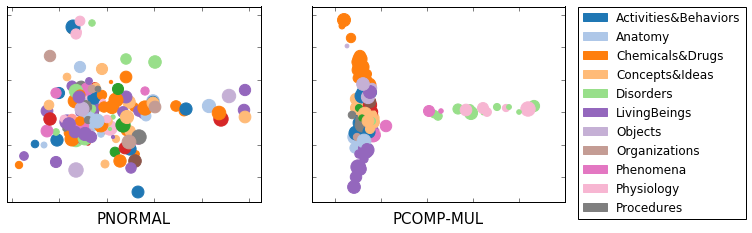

In [140]:
fig = plt.figure(figsize=(10,3.5))
#fig = plt.figure(figsize=(20,10))
np.random.seed(0)

models = ['brescal', 'bcomp_mul']
xlabel_size=15
for model in models:
    dest = '../result_visualisation/%s/' % (dataset)
    if model == 'bcomp_add' or model == 'bcomp_mul':
        output_file = os.path.join(dest, '%s_%.2f_%d_%.2f_%.2f_training_error.pkl' % (
        model, p, n_dim, var_x, var_comp))
    else:
        output_file = os.path.join(dest, '%s_%.2f_%d_training_error.pkl' % (model, p, n_dim))
        
    if model is 'rescal':
        E = pickle.load(open(output_file, 'rb'))
#         tsne = TSNE(n_components=2, random_state=1, method='exact', init='pca')
        tsne = manifold.SpectralEmbedding(n_components=2, n_neighbors=5)        
        embedded = tsne.fit_transform(E)

        ax = plt.subplot(1,3,1)
        for cn in range(0,n_entity):
            if dataset=='umls':
                c = color[uniq_gnames.index(gnames[cn])]
            else:
                c = color[cn]
            plt.scatter(embedded[cn, 0], embedded[cn, 1], color=c)
#             plt.annotate(
#                 cnames[cn], 
#                 xy = (embedded[cn, 0], embedded[cn, 1]), xytext = (10, 5),
#                 textcoords = 'offset points', ha = 'right', va = 'bottom')
            

#         xpad = (np.max(embedded[:,0]) - np.min(embedded[:,0]))/10.
#         ypad = (np.max(embedded[:,1]) - np.min(embedded[:,1]))/10.
#         plt.xlim([np.min(embedded[:,0])-xpad, np.max(embedded[:,0])+xpad])
#         plt.ylim([np.min(embedded[:,1])-ypad, np.max(embedded[:,1])+ypad])
        ax.set_xlabel('RESCAL')
#         plt.xlim([-200,200])
#         plt.ylim([-200,200])    
    
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())

    elif model is 'brescal' or model is 'bcomp_mul':
        Es = pickle.load(open(output_file, 'rb'))
        embeddings = np.zeros([n_iter, n_entity, 2])
        
#         tsne = TSNE(n_components=2, random_state=8, method='exact', init='pca')
        tsne = manifold.SpectralEmbedding(n_components=2, n_neighbors=5)
        embedded = tsne.fit_transform(Es[0])
        embeddings[0] = embedded

        if model is 'brescal':
            ax = plt.subplot(1,2,1)
        else:
            ax = plt.subplot(1,2,2)
        for cn in range(0,n_entity):
            if dataset=='umls':
                c = color[uniq_gnames.index(gnames[cn])]
            else:
                c = color[cn]           
#             plt.scatter(embedded[cn, 0], embedded[cn, 1], s=np.std(Es[:,cn,0])*5000, color=c)
            plt.scatter(embedded[cn, 0], embedded[cn, 1], s=np.random.randint(200)+10, color=c)            
#             plt.annotate(
#                 cnames[cn], 
#                 xy = (embedded[cn, 0], embedded[cn, 1]), xytext = (10, 5),
#                 textcoords = 'offset points', ha = 'right', va = 'bottom')
            
#         xpad = (np.max(embedded[:,0]) - np.min(embedded[:,0]))/10.
#         ypad = (np.max(embedded[:,1]) - np.min(embedded[:,1]))/10.
#         plt.xlim([np.min(embedded[:,0])-xpad, np.max(embedded[:,0])+xpad])
#         plt.ylim([np.min(embedded[:,1])-ypad, np.max(embedded[:,1])+ypad])
#         plt.xlim([-200,200])
#         plt.ylim([-200,200])
        
        if model is 'brescal':
            ax.set_xlabel('PNORMAL', size=xlabel_size)
            plt.xlim([-0.42,0.65])
            plt.ylim([-0.55,0.65])              
        else:
            ax.set_xlabel('PCOMP-MUL', size=xlabel_size)
            plt.xlim([-0.3,0.8])
            plt.ylim([-0.55,0.65])            
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())

predefined = ['Activities_&_Behaviors',
 'Anatomy',
 'Chemicals_&_Drugs',
 'Concepts_&_Ideas',
# 'Devices',
 'Disorders',
# 'Genes_&_Molecular_Sequences',
# 'Geographic_Areas',
 'Living_Beings',
 'Objects',
# 'Occupations',
 'Organizations',
 'Phenomena',
 'Physiology',
 'Procedures']

# patches = [mpatches.Patch(color=color[i], label=group) for i, group in enumerate(uniq_gnames)]
patches = [mpatches.Patch(color=color[i], label=group.replace('_','')) for i, group in enumerate(uniq_gnames) if group in predefined]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('../paper/cikm2016/images/embedding_umls.pdf', format='PDF', bbox_inches='tight', pad_inches=0.1)

In [108]:
uniq_gnames

['Activities_&_Behaviors',
 'Anatomy',
 'Chemicals_&_Drugs',
 'Concepts_&_Ideas',
 'Devices',
 'Disorders',
 'Genes_&_Molecular_Sequences',
 'Geographic_Areas',
 'Living_Beings',
 'Objects',
 'Occupations',
 'Organizations',
 'Phenomena',
 'Physiology',
 'Procedures']